## Example NoiseGrad and NoiseGrad++ text-classification

With a few lines of code we show how to use NoiseGrad and NoiseGrad++ with PyTorch, as a way to enhance text-classification explanation method.

• **Paper:** NoiseGrad: enhancing explanations by introducing stochasticity to model weights
• **Author:** Artem Sereda
• **Institution:** TU Berlin, ML Department, Understandable Machine Intelligence Lab
• **Date:** February, 2023


In [14]:
import torch
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from noisegrad import NoiseGrad, NoiseGradPlusPlus, explainers
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

### Step 1. Load data and model

In [2]:
x_batch = [load_dataset("sst2")["test"]["sentence"][2]]
x_batch

Found cached dataset sst2 (/Users/artemsereda/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

['by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .']

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

In [4]:
input_ids = tokenizer(x_batch, return_tensors="pt")["input_ids"]

In [5]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.numpy().tolist()[0])

In [6]:
y_batch = model(input_ids).logits.detach().argmax(axis=-1)

In [7]:
def embedding_lookup(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.int64, device=input_ids.device)
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    word_embeddings = model.get_input_embeddings()(input_ids)
    position_embeddings = model.get_position_embeddings()(position_ids)
    return word_embeddings + position_embeddings


x_batch_embeddings = embedding_lookup(input_ids)

### Step 2. Initialize methods

In [17]:
ng = NoiseGrad()
ng_pp = NoiseGradPlusPlus()

### Step 3. Get explanations

In [18]:
baseline_scores = explainers.explain_gradient_x_input(
    model, x_batch_embeddings, y_batch, attention_mask=None
).numpy()

In [19]:
ng_scores = ng.enhance_explanation(
    model,
    x_batch_embeddings,
    y_batch,
    explanation_fn=partial(explainers.explain_gradient_x_input, attention_mask=None),
).numpy()

NoiseGrad:   0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
ng_pp_scores = ng_pp.enhance_explanation(
    model,
    x_batch_embeddings,
    y_batch,
    explanation_fn=partial(explainers.explain_gradient_x_input, attention_mask=None),
).numpy()

NoiseGrad++:   0%|          | 0/100 [00:00<?, ?it/s]

### Step 4. Visualize explanations

In [21]:
class ColorMapper:
    """
    - Highest score get red (255,0,0).
    - Lowest score gets blue (0,0,255).
    - Positive scores are linearly interpolated between red and white (255, 255, 255).
    - Negative scores are linearly interpolated between blue and white (255, 255, 255).
    """

    def __init__(self, max_score: float, min_score: float):
        self.max_score = max_score
        self.min_score = min_score

    def to_rgb(self, score: float, normalize_to_1: bool = False):
        k = 1.0 if normalize_to_1 else 255.0

        if score >= 0:
            red = k
            green = k * (1 - score / self.max_score)
            blue = k * (1 - score / self.max_score)
        else:
            red = k * (1 - abs(score / self.min_score))
            green = k * (1 - abs(score / self.min_score))
            blue = k
        return red, green, blue


def visualise_explanations_as_pyplot(explanations, labels):

    h_len = len(explanations)
    v_len = len(explanations[0][0])

    tokens = [i[0] for i in explanations]
    scores = [i[1] for i in explanations]

    fig, axes = plt.subplots(
        h_len,
        v_len,
        figsize=(v_len * 0.75, h_len * 1.25),
        gridspec_kw=dict(left=0.0, right=1.0),
    )
    hspace = 1.0 if labels is not None else 0.1
    plt.subplots_adjust(hspace=hspace, wspace=0.0)
    for i, ax in enumerate(axes):
        color_mapper = ColorMapper(np.max(scores[i]), np.min(scores[i]))
        if labels:
            ax[v_len // 2].set_title(labels[i])
        for j in range(v_len):
            color = color_mapper.to_rgb(scores[i][j], normalize_to_1=True)
            rect = plt.Rectangle((0, 0), 1, 1, color=color)
            ax[j].add_patch(rect)
            ax[j].text(0.5, 0.5, tokens[i][j], ha="center", va="center")
            ax[j].set_xlim(0, 1)
            ax[j].set_ylim(0, 1)
            ax[j].axis("off")
            ax[j] = fig.add_axes([0, 0.05, 1, 0.9], fc=[0, 0, 0, 0])

    ax = axes.ravel()[-1]
    for axis in ["left", "right"]:
        ax.spines[axis].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    return fig

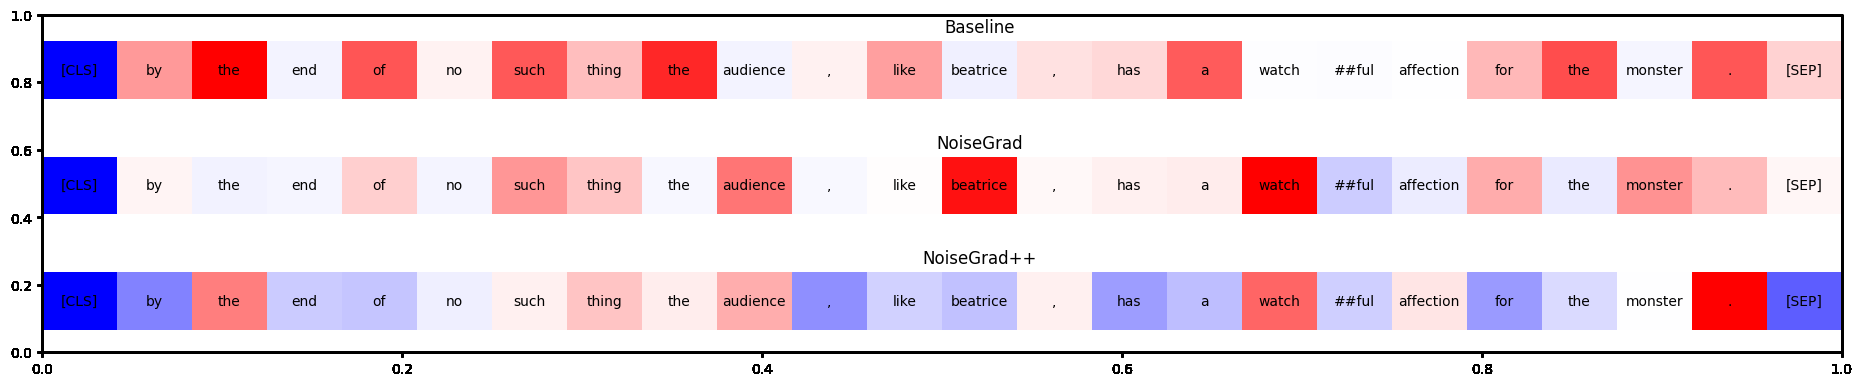

In [24]:
visualise_explanations_as_pyplot(
        [
            (tokens, baseline_scores[0]),
            (tokens, ng_scores[0]),
            (tokens, ng_pp_scores[0]),
        ],
        labels=["Baseline", "NoiseGrad", "NoiseGrad++"],
)
plt.show()